# Loading Libraries

In [1]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import imageio

In [2]:
from matplotlib import pyplot as plt

In [3]:
import seaborn as sns
sns.set_style("darkgrid")

# Utility Functions

In [4]:
def loadData(path):
    """ X = Images and Y = masks """

    train_x = sorted(glob(os.path.join(path, "training", "images", "*.tif")))
    mask_x =  sorted(glob(os.path.join(path, "training", "mask", "*.tif")))
    train_y = sorted(glob(os.path.join(path, "training", "1st_manual", "*.gif")))
    return (train_x, mask_x,train_y)

In [5]:
def createDir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [6]:
# def squareRescale(image, power = 1.0):
#     table = np.array([[i//(256**power) for i in row] for row in image]).astype("uint16")
#     return table

# Loading The Data Set

In [7]:
""" Seeding """
np.random.seed(42)

""" Load the data """
data_path = "D:\\Data sets\\DRIVE"
(train_x, mask_x, train_y) = loadData(data_path)

print(f"Train: {len(train_x)} - {len(train_y)} - {len(mask_x)}")


Train: 20 - 20 - 20


# The Image

In [8]:
x = train_x[0]
y = train_y[0]
m = mask_x[0]
""" Reading image and mask """
src = cv2.imread(x, cv2.IMREAD_COLOR)
x = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
green = x[:,:,1]

m  = mask  = cv2.imread(m, cv2.IMREAD_COLOR)
y = imageio.mimread(y)[0]




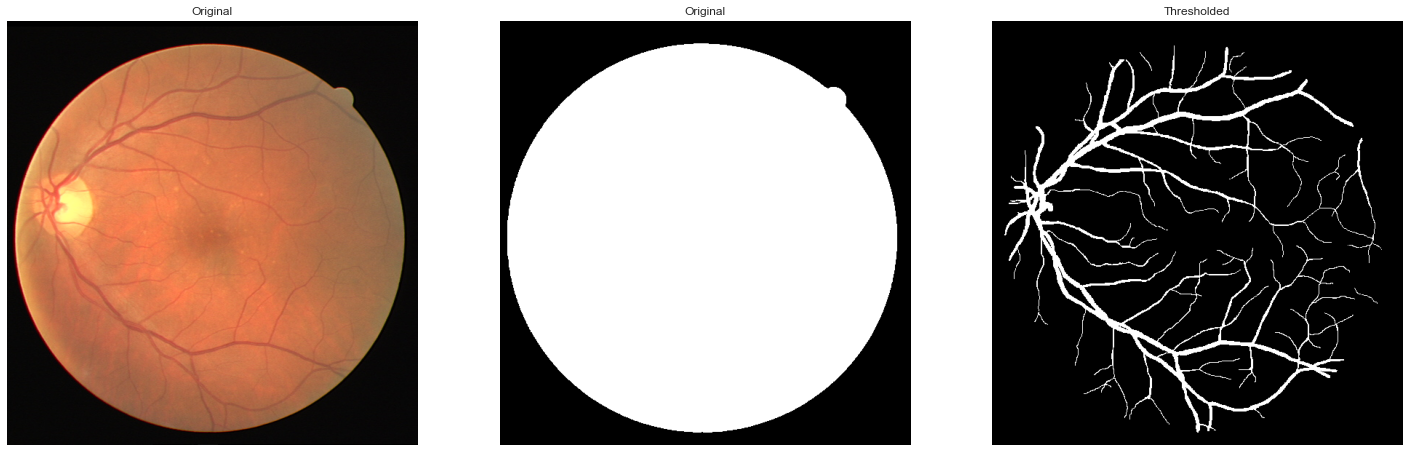

In [9]:
fig, axes = plt.subplots(ncols=3, figsize=(25, 25))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(x)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(m)
ax[1].set_title('Original')
ax[1].axis('off')
ax[2].imshow(y, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')
plt.show()

In [10]:
bins_num = 256

hist_x, bin_edges = np.histogram(green, bins=bins_num)

In [11]:
hist_x = hist_x.ravel()
hist_x

array([ 6992,   588,   290,   269,   575,  3690, 17157, 33251, 28152,
       10141,  2382,   621,   169,    65,    48,    60,    37,    33,
          25,    20,    21,    34,    23,    17,    20,    16,    17,
          29,    24,    22,    24,    26,    22,    23,    15,    30,
          19,    23,    14,    28,    17,    26,    16,    21,    13,
          20,     7,    31,    13,    17,    19,    19,    13,    22,
          24,    22,     9,    19,    26,    27,    19,    14,    21,
          19,    20,    19,    23,    18,    26,    21,    22,    29,
          18,    15,    20,    12,    24,    25,    25,    50,    56,
          72,    91,    87,   141,   212,   235,   312,   375,   425,
         498,   610,   666,   815,   939,  1176,  1422,  1682,  2133,
        2430,  2606,  2893,  3088,  3480,  3665,  4330,  5349,  6545,
        7965,  8853,  9643,  9517,  9230,  8609,  7958,  7526,  7115,
        6586,  6408,  6258,  5969,  5598,  5468,  5137,  4940,  4550,
        4281,  4032,

In [12]:
mean_x = np.mean(green)
std_x = np.std(green)
var_x = np.var(green)

print(mean_x, std_x, var_x)

82.78365559461753 54.141895474773975 2931.3448456013507


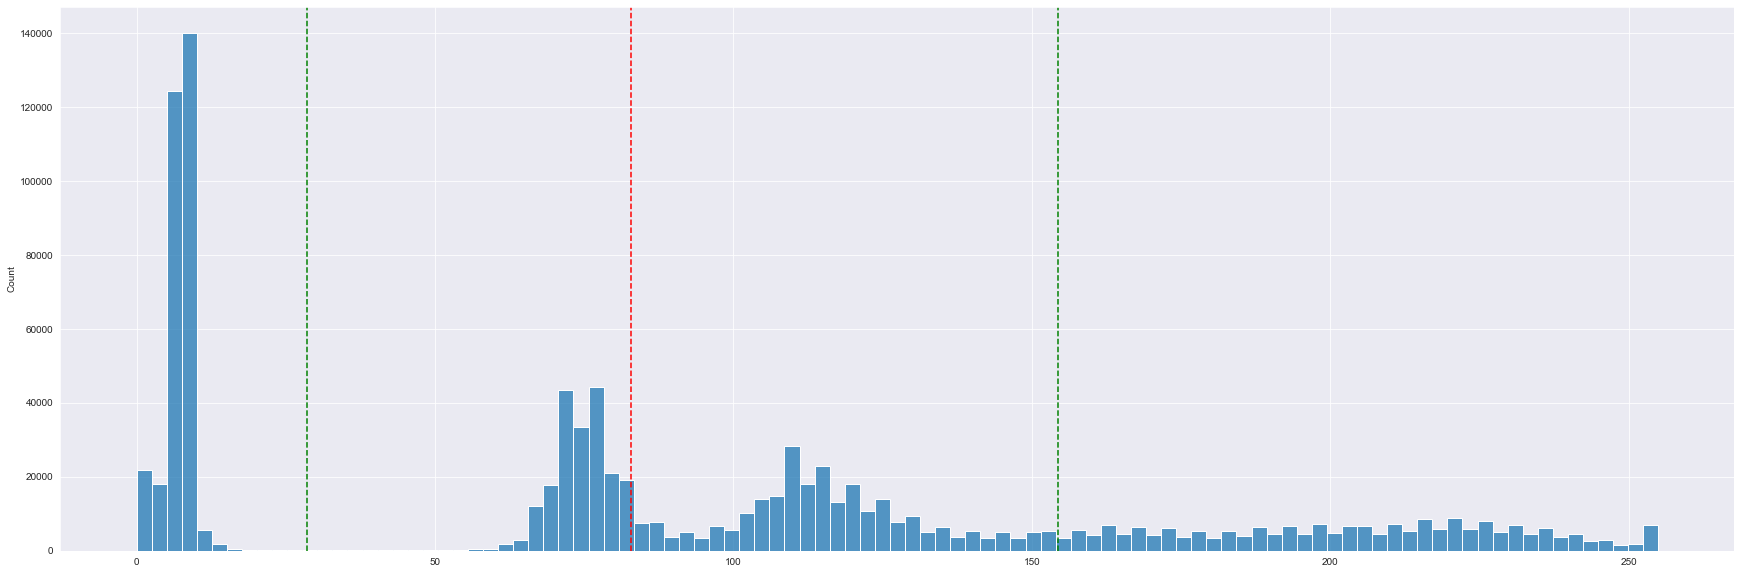

In [13]:
plt.figure(figsize=(30,10))
fig = sns.histplot(data= x.ravel())
fig.axvline(mean_x, ls='--', c = "red")
fig.axvline(mean_x + std_x + 17.5, ls='--', c = "green")
fig.axvline(mean_x - std_x, ls='--', c = "green")

In [14]:
def adjust_gamma(image, gamma=1.0):

    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
    for i in np.arange(0, 256)]).astype("uint8")

    return cv2.LUT(image, table)

In [15]:
def advanced_gamma(image, mean, std, gamma= 1/2.2):
    r1 = mean - std
    
    invGamma = 1.0 / gamma
    
    
    table = np.array([(i / 255.0) * 255 for i in np.arange(0, 256)]).astype("uint8")

#     for i in range(0,r1+1):
#         table[i] = int(((i / 255.0) ** invGamma) * 255)
    
    for i in range(r1, 256):
        table[i] = int(((i / 255.0) ** invGamma) * 255)
    
#     for i in range(r2,256):
#         table[i] = int(((i / 255.0) ** invGamma) * 255)
    
    
    return cv2.LUT(image, table)

# Generalized Pre-Processing Function

In [16]:
def calculate_stat(images, ch = 1):
    mean_arr = []
    std_arr = []
    for x in images:               
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        green = x[:,:,ch]
        
        mean_arr.append(np.mean(green))
        std_arr.append(np.std(green))
        
        
    return sum(mean_arr)/len(mean_arr), sum(std_arr)/len(std_arr)
        

In [17]:
total_mean, total_std = calculate_stat(train_x, 2)

In [18]:
total_mean,total_std

(126.83705873439207, 84.57063232832671)

In [19]:
def transform_img(image):
    #Red Channel
    red_mean, red_std = int(41), int(25)
    red_channel = advanced_gamma(image[:,:,0], red_mean, red_std)
    
    #Green Channel
    green_mean, green_std = int(69), int(45)
    green_channel = advanced_gamma(image[:,:,1], green_mean, green_std)
    
    #Blue Channel
    blue_mean, blue_std = int(127), int(85)
    blue_channel = advanced_gamma(image[:,:,2], blue_mean, blue_std)
    
    merge = cv2.merge([red_channel, green_channel, blue_channel])
    return merge

In [20]:
ig3 = transform_img(x)
t = 255 - ig3

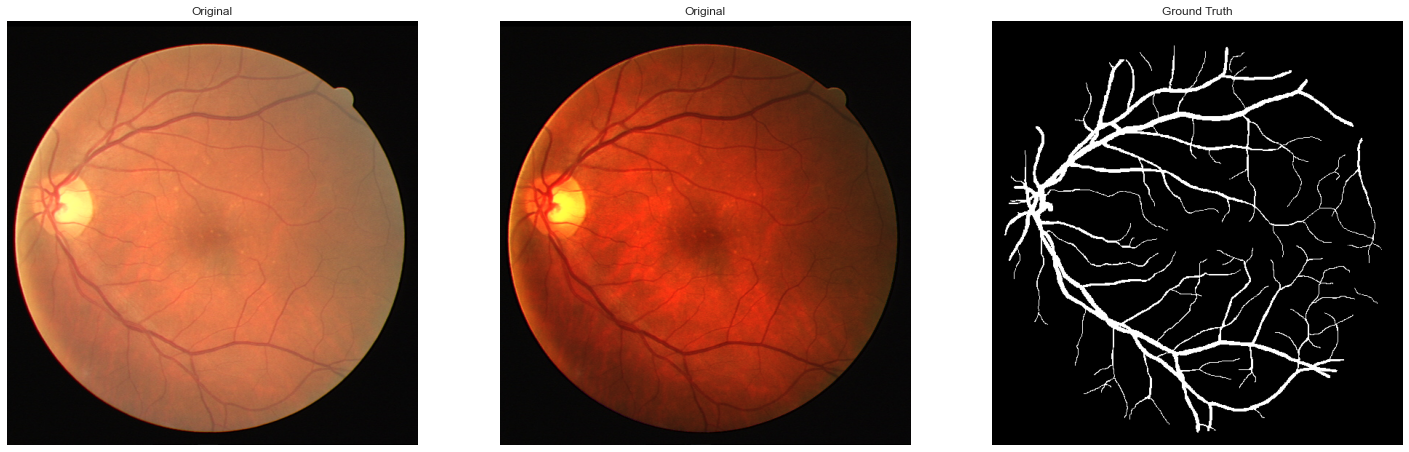

In [21]:
fig, axes = plt.subplots(ncols=3, figsize=(25, 25))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(x)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(ig3, cmap=plt.cm.gray)
ax[1].set_title('Original')
ax[1].axis('off')
ax[2].imshow(y, cmap=plt.cm.gray)
ax[2].set_title('Ground Truth')
ax[2].axis('off')
plt.show()

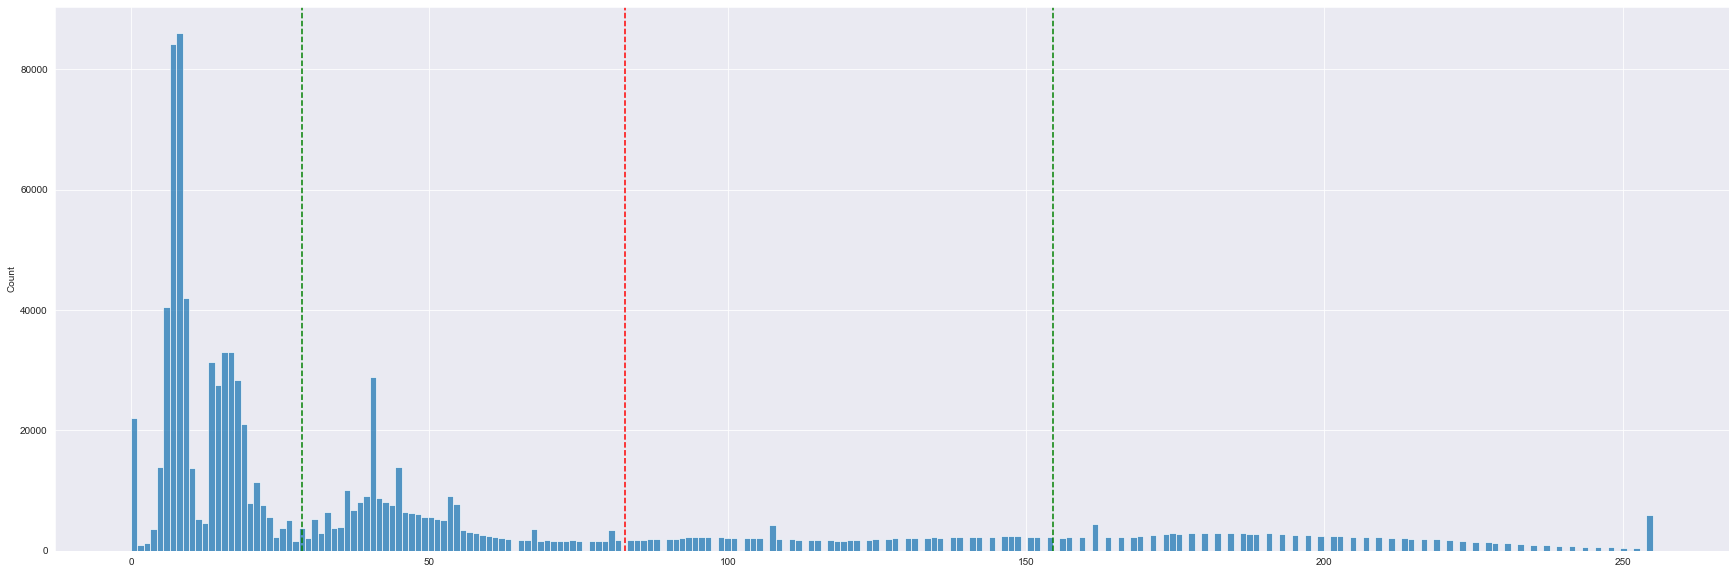

In [22]:
plt.figure(figsize=(30,10))
fig = sns.histplot(data= ig3.ravel())
fig.axvline(mean_x, ls='--', c = "red")
fig.axvline(mean_x + std_x + 17.5, ls='--', c = "green")
fig.axvline(mean_x - std_x, ls='--', c = "green")

# The Adaptive Gamma Transformation

In [23]:
def image_stat(image, ch = 1):
    channel = image[:,:,ch]
    return int(np.mean(channel)), int(np.std(channel))

In [24]:
def transform_adaimg(image):
    #Red Channel
    red_mean, red_std = image_stat(image,0)
    red_channel = advanced_gamma(image[:,:,0], red_mean, red_std)
#     print(red_mean, red_std)
    
    #Green Channel
    green_mean, green_std = image_stat(image,1)
    green_channel = advanced_gamma(image[:,:,1], green_mean, green_std)
    
    #Blue Channel
    blue_mean, blue_std = image_stat(image,2)
    blue_channel = advanced_gamma(image[:,:,2], blue_mean, blue_std)
    
    merge = cv2.merge([red_channel, green_channel, blue_channel])
    return merge

In [34]:
ig4 = transform_adaimg(x)

In [53]:
def green_adaimg(image):
    l,w,h = image.shape
    
    #Red and blue
    null = np.array([0 for i in np.arange(0, 256)]).astype("uint8")
    null_channel = cv2.LUT(image[:,:,0], null)
    
    #Green Channel
    green_mean, green_std = image_stat(image,1)
    green_channel = advanced_gamma(image[:,:,1], green_mean, green_std)
    print(null.shape)
    
    merge = cv2.merge([null_channel, green_channel, null_channel])
    return merge

In [54]:
trans_green = green_adaimg(x)

(256,)


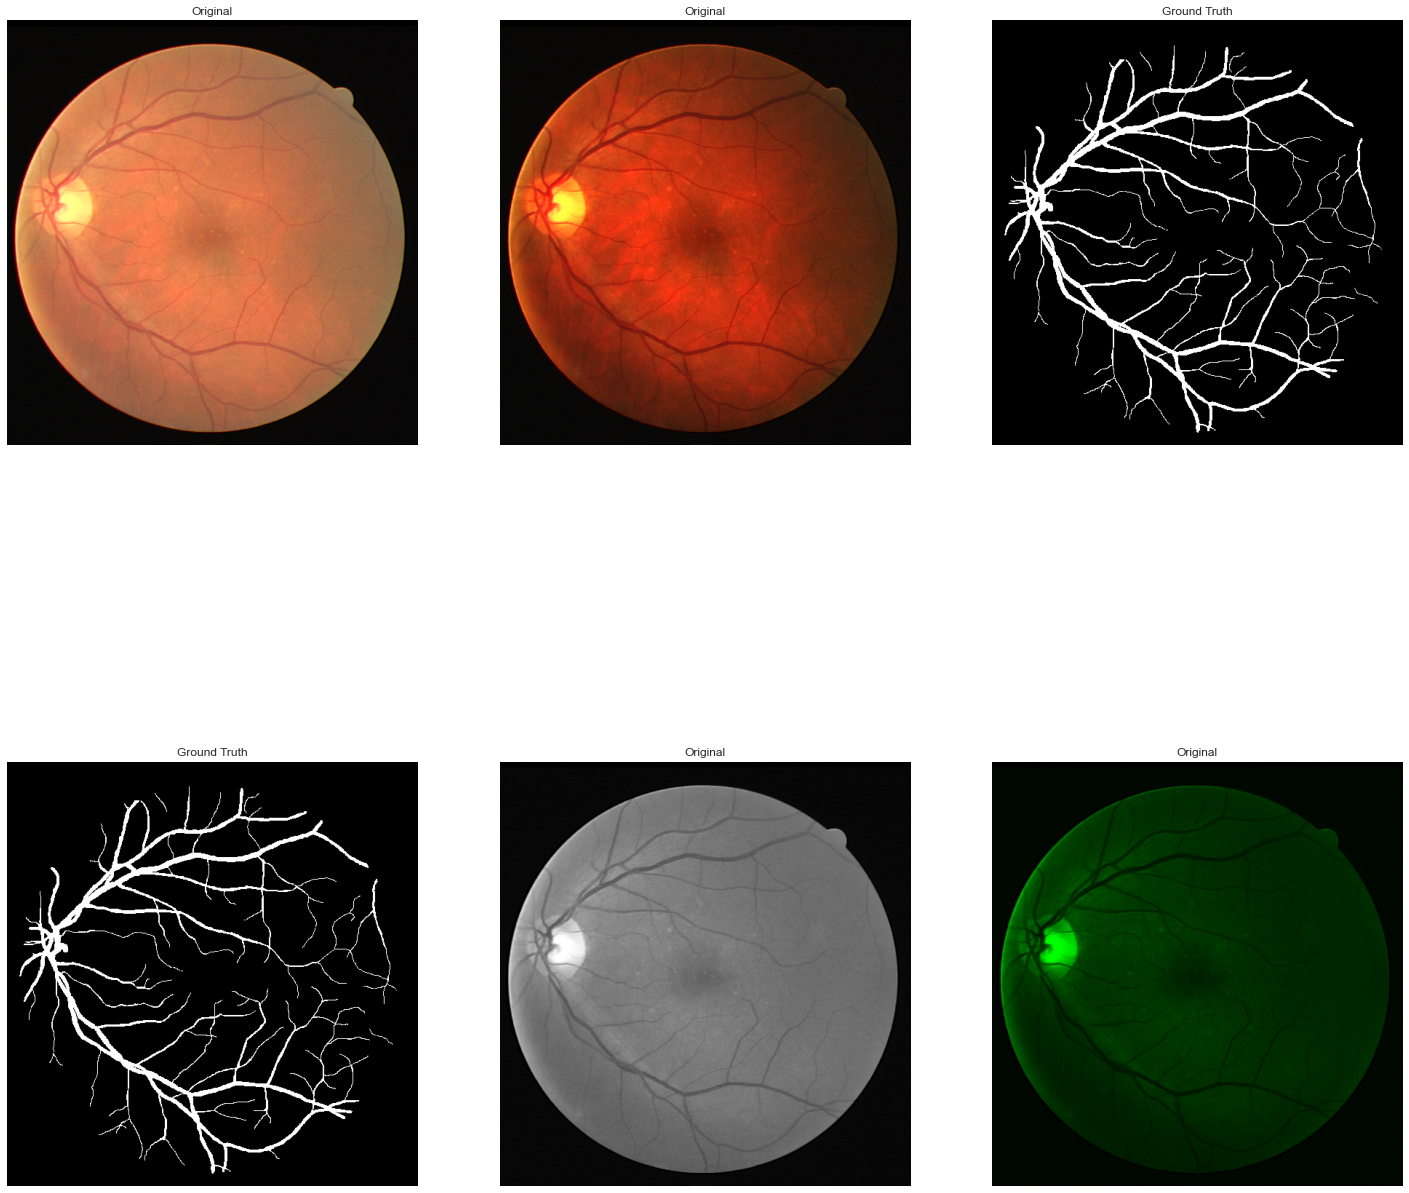

In [56]:
fig, axes = plt.subplots(2,3, figsize=(25, 25))
ax = axes.ravel()

ax[0].imshow(x)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(ig4, cmap=plt.cm.gray)
ax[1].set_title('Original')
ax[1].axis('off')
ax[2].imshow(y, cmap=plt.cm.gray)
ax[2].set_title('Ground Truth')
ax[2].axis('off')
ax[3].imshow(y, cmap=plt.cm.gray)
ax[3].set_title('Ground Truth')
ax[3].axis('off')
ax[4].imshow(green, cmap=plt.cm.gray)
ax[4].set_title('Original')
ax[4].axis('off')
ax[5].imshow(trans_green, cmap=plt.cm.gray)
ax[5].set_title('Original')
ax[5].axis('off')

plt.show()